In [1]:
!pip install casadi
from IPython.display import clear_output
import os
import time

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

# 定数

In [2]:
# 2Dドローンのパラメータ
m = 1
# J = 2.5 * 1e-4
J = 1e-1
l = 0.086
g = 9.81

nx = 6 #状態変数の次元
nu = 2 #制御変数の次元

# 後退ホライズン等
dt = 0.05

#コスト行列
Q = casadi.diag([10,10,10,10,10,10])
Q_f = casadi.diag([10,10,10,10,10,10])
R = casadi.diag([0.1,0.1])

# 制約条件
x_lb = [-10,-10,-np.pi/2,-10,-10,-10]
x_ub = [10,10,np.pi/2,10,10,10]
u_lb = [0,0]
u_ub = [10,10]

#目標値
x_ref = casadi.DM([3,3,0,0,0,0])
u_ref = casadi.DM([m*g/2,m*g/2])

# 状態方程式・積分器・コスト関数

In [3]:
def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    x = states[0]
    y = states[1]
    theta = states[2]
    x_dot = states[3]
    y_dot = states[4]
    theta_dot = states[5]
    f1 = ctrls[0]
    f2 = ctrls[1]

    x_ddot = -g*theta
    y_ddot = (f1+f2)/m -g
    theta_ddot = (f1-f2)*l/J

    states_dot = casadi.vertcat(x_dot,y_dot,theta_dot,x_ddot,y_ddot,theta_ddot)

    f = casadi.Function("f",[states,ctrls],[states_dot],['x','u'],['x_dot'])
    return f

def make_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()

    r1 = f(x=states,u=ctrls)["x_dot"]
    r2 = f(x=states+dt*r1/2,u=ctrls)["x_dot"]
    r3 = f(x=states+dt*r2/2,u=ctrls)["x_dot"]
    r4 = f(x=states+dt*r3,u=ctrls)["x_dot"]

    states_next = states + dt*(r1+2*r2+2*r3+r4)/6

    RK4 = casadi.Function("RK4",[states,ctrls],[states_next],["x","u"],["x_next"])
    return RK4

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()
    ode = f(x=states, u=ctrls)["x_dot"]

    dae = {"x":states,"p":ctrls,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(x,u):
    x_diff = x - x_ref
    u_diff = u - u_ref
    cost = (casadi.dot(Q@x_diff,x_diff) + casadi.dot(R@u_diff,u_diff)) / 2
    return cost

def compute_terminal_cost(x):
    x_diff = x - x_ref
    cost = casadi.dot(Q_f@x_diff,x_diff) / 2
    return cost

# 最適化問題

In [4]:
def make_qps_multiple(K):
    RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k],U[k]) * dt
        eq = X[k+1] - RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_terminal_cost(X[-1])

    qp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}

    S_osqp = casadi.qpsol("S","osqp",qp)

    option_qpoases = {"printLevel":"none","sparse":True}
    S_qpoases = casadi.qpsol("S","qpoases",qp,option_qpoases)

    option_ipqp = {
        "linear_solver":"ldl",
        "print_header":False,
        "print_info":False,
        "print_iter":False}
    S_ipqp = casadi.qpsol("S","ipqp",qp,option_ipqp)
    return S_osqp, S_qpoases, S_ipqp

def make_qp_single(K):
    RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    x_init = casadi.SX.sym("x_init",nx)

    J = 0

    x_tmp = x_init
    for k in range(K):
        J += compute_stage_cost(x_tmp,U[k]) * dt
        x_tmp = RK4(x=x_tmp,u=U[k])["x_next"]
    J += compute_terminal_cost(x_tmp)

    qp = {"x":casadi.vertcat(x_init,*U),"f":J}
    # S = casadi.qpsol("S","osqp",qp)
    option_qpoases = {"printLevel":"none","sparse":False}
    S = casadi.qpsol("S","qpoases",qp,option_qpoases)
    return S

# 最適な制御入力の計算

In [5]:
def compute_optimal_control_multiple(S,x_init,x0,K):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [-1e-8]*nx*K
    ubg = [1e-8]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

def compute_optimal_control_single(S,x_init,x0,K):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + u_lb*K
    ubx = x_init + u_ub*K
    # lbg = [-1e-8]*nx*K
    # ubg = [1e-8]*nx*K

    res = S(lbx=lbx,ubx=ubx,x0=x0)
    
    offset = nx
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

# MPC


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.



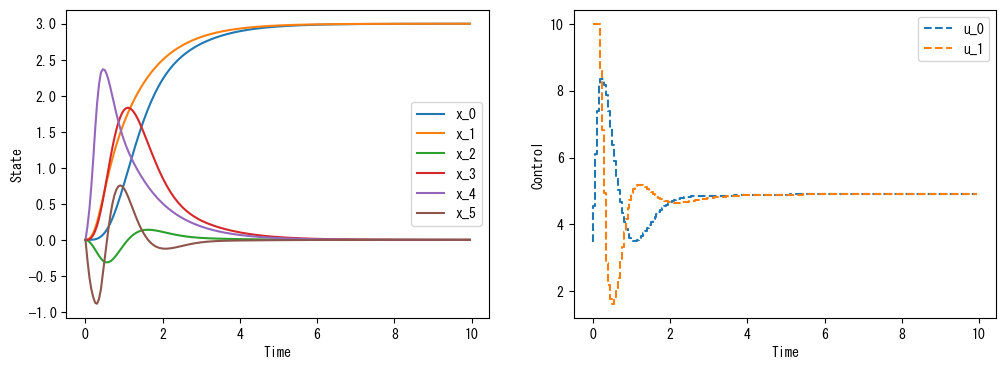

In [6]:
K = 20
S = make_qps_multiple(K)[0]

t_span = [0,10]
t_eval = np.arange(*t_span,dt)
I = make_integrator()

x_init = casadi.DM([0,0,0,0,0,0]) # 初期値
total = nx*(K+1) + nu*K
x0 = casadi.DM.zeros(total)

X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt,x0 = compute_optimal_control_multiple(S,x_current,x0,K=20)
    x_current = I(x0=x_current,p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)

# 結果の可視化

In [ ]:
X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("State")

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Control")

plt.savefig("images/chap7_2d_quad_mpc_osqp.png")
plt.show()

# アニメーションの作成

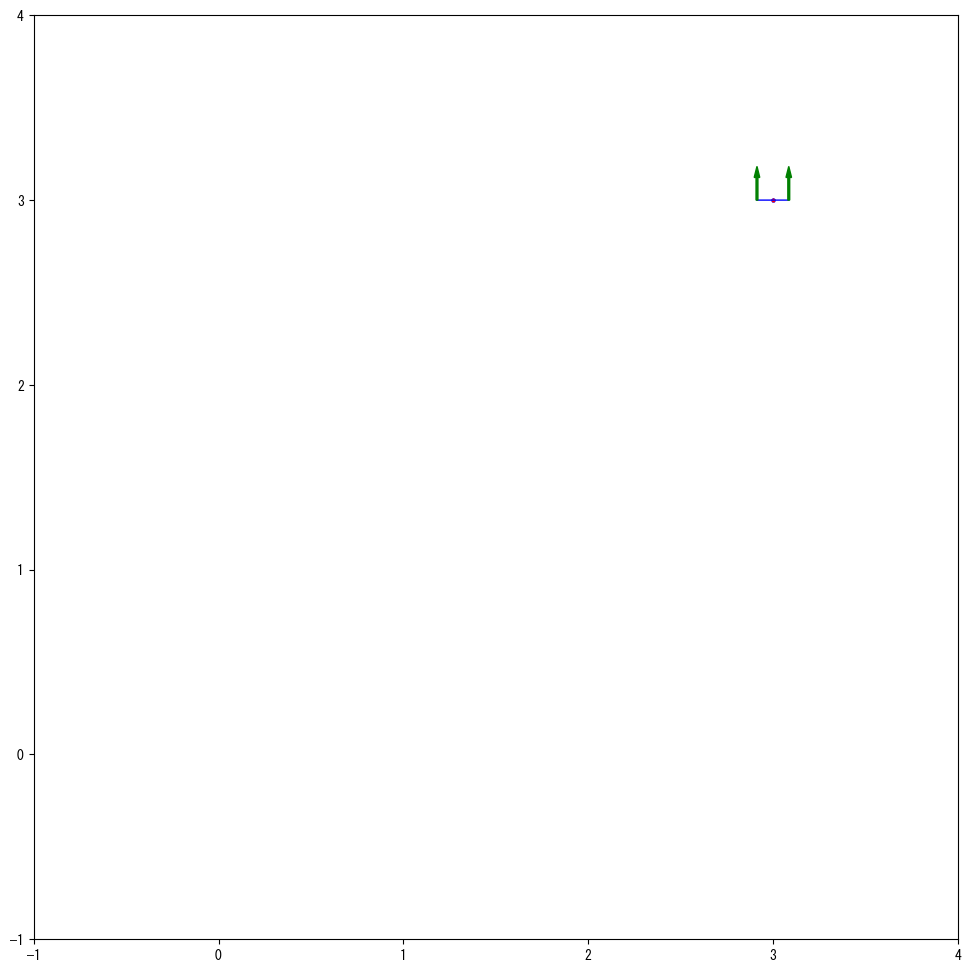

In [7]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
frames = np.arange(0,t_eval.size)
fps = 1 / dt

def update_figure(i):
    x_lim_min = -1
    x_lim_max = 4
    y_lim_min = -1
    y_lim_max = 4
    u_scale = 40

    ax.cla()
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.set_ylim(y_lim_min, y_lim_max)
    ax.set_aspect("equal")

    x,y,theta,_,_,_ = X[i]
    f1,f2 = U[i]

    center = np.array([x,y])
    left = center - l*np.array([np.cos(theta),np.sin(theta)])
    right = center + l*np.array([np.cos(theta),np.sin(theta)])
    points = np.stack([left,right],axis=0)
    ref = x_ref[:2].full().ravel()
    
    left_f = f2*np.array([-np.sin(theta),np.cos(theta)])
    right_f = f1*np.array([-np.sin(theta),np.cos(theta)])

    ax.scatter(*center,color="blue",s=5)
    ax.scatter(*ref,color="red",s=5,marker="*")
    ax.plot(*points.T, color='blue', lw=1)

    ax.arrow(*left,*left_f/u_scale,width=0.01,head_width=0.03,head_length=0.06,length_includes_head=False,color="green",zorder=3)
    ax.arrow(*right,*right_f/u_scale,width=0.01,head_width=0.03,head_length=0.06,length_includes_head=False,color="green",zorder=3)

ani = FuncAnimation(fig, update_figure, frames=frames)
ani.save("images/chap7_2d_quadrotor.gif",writer="pillow",fps=fps)

# QPソルバーの計算時間の比較

In [8]:
def comparison():
    I = make_integrator()

    x_init = casadi.DM([0,0,0,0,0,0]) # 初期値

    K_list = np.arange(1,120,5)
    Times = []
    solver_name_list = ["OSQP","qpOASES (Multiple)", "ipqp","qpOASES (Single)"]
    func_list = [compute_optimal_control_multiple]*3+[compute_optimal_control_single]

    for K in K_list:
        x0_m = casadi.DM.zeros(nx*(K+1) + nu*K)
        x0_s = casadi.DM.zeros(nx + nu*K)
        x0_list = [x0_m,x0_m,x0_m,x0_s]
        qp_list = list(make_qps_multiple(K=K)) + [make_qp_single(K=K)]
        for qp_sol, x0, compute in zip(qp_list,x0_list,func_list):
            start_time = time.perf_counter()
            _ = compute(qp_sol,x_init,x0,K=K)
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            Times.append(elapsed_time)

    Times = np.array(Times)
    Times = Times.reshape(-1,4).T

    for times,names in zip(Times, solver_name_list):
        plt.plot(K_list, times,label=names)
    plt.legend()
    plt.ylim((0,0.02))
    plt.xlabel("Time")
    plt.ylabel("Elapsed Time")

    plt.savefig("images/chap7_2d_quad_mpc_comparison.png")
    plt.show()


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Onl

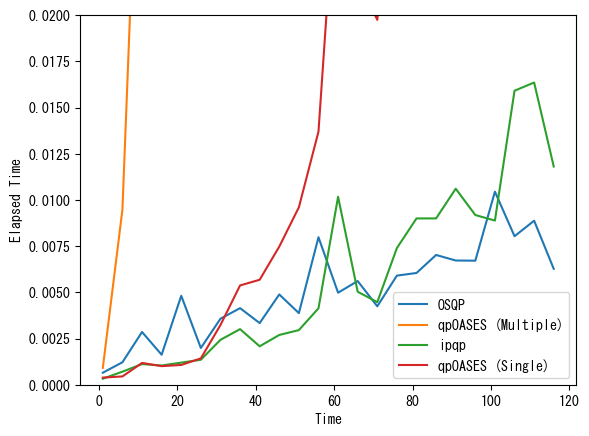

In [9]:
comparison()